<a href="https://colab.research.google.com/github/greenteausa/DATA606_Capstone/blob/main/Capstone_Stage_II/Capstone_project_of_PointNetClass_Stage_II_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PointNet

This is an implementation of [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593) using PyTorch.


## Getting started, import some modules.

Don't forget to turn on GPU if you want to start training directly. 


**Runtime** -> **Change runtime type**-> **Hardware accelerator**



In [3]:
pip install -U gif

     |████████████████████████████████| 2.2MB 5.7MB/s 
  Created wheel for gif: filename=gif-3.0.0-cp37-none-any.whl size=4817 sha256=5ef34c4134f2ad4a8c096129a62d34d1c1c2fa8b732563d1d51685934690206a
  Stored in directory: /root/.cache/pip/wheels/33/1a/03/e7ccc13d5cbed82b0fda53a7792dfe372cf8baf691601d78d1
Successfully built gif
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [4]:
pip install "gif[plotly]"

     |████████████████████████████████| 79.9MB 64kB/s 
     |████████████████████████████████| 13.2MB 54.3MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [5]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision 

#import gif

import plotly.graph_objects as go # for the file visualization.
import plotly.express as px # not used in this notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.backends.cudnn.deterministic=True
random.seed = 42 #set_seed(42)

In [6]:
!pip install path.py;
from path import Path

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Prepare dataset.

In [8]:
vessel_file = "/content/gdrive/My Drive/Capstone_606/IntrA/generated/vessel/"
aneurysm_file = "/content/gdrive/My Drive/Capstone_606/IntrA/generated/aneurysm/"

IntA has annotated file, compleated file, generated file.

Generated file has 1694 vessel .ad file  which includes some point cloud data and 1694 .obj file which is mesh data.

In [9]:
d = [i for i in os.listdir('/content/gdrive/My Drive/Capstone_606/IntrA/generated/')]
d 

['.DS_Store', 'vessel', 'aneurysm', 'ad', 'obj']

In [10]:
vessel_ad = [i for i in os.listdir('/content/gdrive/My Drive/Capstone_606/IntrA/generated/ad/vessel_ad')]
print('Generated vessel has total %d ad files.' %len(vessel_ad))
vessel_obj = [i for i in os.listdir('/content/gdrive/My Drive/Capstone_606/IntrA/generated//obj/vessel_obj')]
print('Generated vessel has total %d obj files.' %len(vessel_obj))
aneurysm_ad = [i for i in os.listdir('/content/gdrive/My Drive/Capstone_606/IntrA/generated/ad/aneurysm_ad')]
print('Generated aneurysm has total %d ad files.' %len(aneurysm_ad))
aneurysm_obj = [i for i in os.listdir('/content/gdrive/My Drive/Capstone_606/IntrA/generated/obj/aneurysm_obj/')]
print('Generated aneurysm has total %d obj files.' %len(aneurysm_obj))
annotated_ad = [i for i in os.listdir('/content/gdrive/My Drive/Capstone_606/IntrA/annotated/ad')]
print('annotated has total %d ad files.' %len(annotated_ad))
annotated_obj = [i for i in os.listdir('/content/gdrive/My Drive/Capstone_606/IntrA/annotated/ad')]
print('annotated has total %d obj files.' %len(annotated_obj))
complete_adj = [i for i in os.listdir('/content/gdrive/My Drive/Capstone_606/IntrA/complete')]
print('complete has total %d odj files.'% len(complete_adj))
all_image_path = vessel_ad + aneurysm_ad
len(all_image_path)


Generated vessel has total 1694 ad files.
Generated vessel has total 1694 obj files.
Generated aneurysm has total 215 ad files.
Generated aneurysm has total 215 obj files.
annotated has total 116 ad files.
annotated has total 116 obj files.
complete has total 103 odj files.


1909

In [11]:
all_image_path = vessel_ad + aneurysm_ad
len(all_image_path)

1909

## Visualization in colab

### Load .ad file.

In [12]:
def load_ad_file(path):
    points = []
    labels = []
    normals = []

    with open(path, 'r') as f:
        for line in f.readlines():
            s_line = line.split()
            points.append([float(s_line[0]), float(s_line[1]), float(s_line[2])])
            normals.append([float(s_line[3]), float(s_line[4]), float(s_line[5])])
            labels.append(int(s_line[6]))

    return points, labels, normals

In [13]:
#for the .ad file point cloud show.
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color= labels)),
                      selector=dict(mode='markers'))
    fig.show()  

In [14]:
#Define the function for the .ad files mesh table style show.
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]
    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [34]:
#Demo show for .ad file (both the point cloud and mesh table)
path = '/content/gdrive/My Drive/Capstone_606/IntrA/generated/ad/aneurysm_ad/ArteryObjAN218-16_addon.ad'
points, labels, normals = load_ad_file(path)# for the cloud point show.
x, y, z = np.array(points).T
pcshow(x,y,z)# for cloud point show
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,mode='markers')]).show()# for mesh table show.

In [17]:
#Another demo show for the anootated .ad file for the aneurysm sample.
path_1 = '/content/gdrive/My Drive/Capstone_606/IntrA/annotated/ad/AN218-_norm.ad'
points, labels, normals = load_ad_file(path_1)
x, y, z = np.array(points).T
pcshow(x,y,z)# for cloud point show
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,mode='markers')]).show()# for mesh table show.

### Load complete obj file.

In [21]:
def load_obj_file(filename):
    points = []
    a_points = []
    o_points = []
    a_faces = []
    o_faces = []
    faces = []
    group = None

    with open(filename, 'r') as f:
        lines = f.readlines()
        
        for i, line in enumerate(lines):
            if line.startswith("#"):
              continue
            else:
              s_line = line.split()
            if len(s_line) > 0:
                if s_line[0] == 'v':
                    points.append((float(s_line[1]), float(s_line[2]), float(s_line[3])))
                if s_line[0] == 'g' and s_line[1][0] == 'a':
                    group = 'a'
                if s_line[0] == 'g' and s_line[1][0] == 'o':
                    group = 'o'
                if s_line[0] == 'f' and group == 'a':
                    f = (int(s_line[1]) - 1, int(s_line[2]) - 1, int(s_line[3]) - 1)
                    a_faces.append(f)
                    a_points.append(f[0])
                    a_points.append(f[1])
                    a_points.append(f[2])
                if s_line[0] == 'f' and group == 'o':
                    f = (int(s_line[1]) - 1, int(s_line[2]) - 1, int(s_line[3]) - 1)
                    o_faces.append(f)
                    o_points.append(f[0])
                    o_points.append(f[1])
                    o_points.append(f[2])
                if s_line[0] == 'f':
                    f = (int(s_line[1]) - 1, int(s_line[2]) - 1, int(s_line[3]) - 1)
                    faces.append(f)


        # points = list({}.fromkeys(points).keys())
        print(len(points))

        a_points = list({}.fromkeys(a_points).keys())
        a_points.sort()
        o_points = list({}.fromkeys(o_points).keys())
        o_points.sort()

        print(len(a_points))
        print(len(o_points))
        print(len(faces))


    return points, a_points, o_points, a_faces, o_faces, faces

In [22]:
path_2 = '/content/gdrive/My Drive/Capstone_606/IntrA/complete/ArteryObjAN219.obj'
points, a_points, o_points, a_faces, o_faces, faces = load_obj_file(path_2)
i,j,k = np.array(faces).T
x,y,z = np.array(points).T
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i, j=j, k=k)]).show()

55835
0
0
111726


### Load annotated obj file

In [23]:
def load_anno_obj(filename):
    points = []
    n_points = []
    a_points = []
    o_points = []
    a_faces = []
    o_faces = []
    faces = []
    group = None

    with open(filename, 'r') as f:
        lines = f.readlines()
        
        for i, line in enumerate(lines):
            if line.startswith("#"):
              continue
            else:
              s_line = line.split()
              print(s_line)
            if len(s_line) > 0:
                if s_line[0] == 'v':
                    points.append((float(s_line[1]), float(s_line[2]), float(s_line[3])))
                if s_line[0] == 'vn':
                    n_points.append((float(s_line[1]), float(s_line[2]), float(s_line[3])))
                if s_line[0] == 'g' and s_line[1][0] == 'a':
                    group = 'a'
                if s_line[0] == 'g' and s_line[1][0] == 'o':
                    group = 'o'
                if s_line[0] == 'f' and group == 'a':
                    f = (int(s_line[1]) - 1, int(s_line[2]) - 1, int(s_line[3]) - 1)
                    a_faces.append(f)
                    a_points.append(f[0])
                    a_points.append(f[1])
                    a_points.append(f[2])
                if s_line[0] == 'f' and group == 'o':
                    f = (int(s_line[1]) - 1, int(s_line[2]) - 1, int(s_line[3]) - 1)
                    o_faces.append(f)
                    o_points.append(f[0])
                    o_points.append(f[1])
                    o_points.append(f[2])
                if s_line[0] == 'f':
                    f = (int(s_line[1].split("//")[0]) - 1, int(s_line[2].split("//")[0]) - 1, int(s_line[3].split("//")[0]) - 1)
                    faces.append(f)


        # points = list({}.fromkeys(points).keys())
        print(len(points))

        a_points = list({}.fromkeys(a_points).keys())
        a_points.sort()
        o_points = list({}.fromkeys(o_points).keys())
        o_points.sort()

        print(len(a_points))
        print(len(o_points))
        print(len(faces))


    return points, a_points, o_points, a_faces, o_faces, faces, n_points

In [24]:
path_3 = '/content/gdrive/My Drive/Capstone_606/IntrA/annotated/obj/AN1_full.obj'
points, a_points, o_points, a_faces, o_faces, faces, n_points = load_anno_obj(path_3)
i,j,k = np.array(faces).T
x,y,z = np.array(points).T
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i, j=j, k=k)]).show()

['vn', '-0.963639', '-2.877204', '-5.258200']
['v', '33.355099', '-69.973701', '-11.218000']
['vn', '0.807457', '-2.006661', '-5.669837']
['v', '33.941002', '-69.984200', '-11.220500']
['vn', '-3.818356', '-1.924736', '-3.700850']
['v', '32.673199', '-69.474800', '-11.200000']
['vn', '-1.916236', '-1.660495', '-5.424212']
['v', '32.938000', '-69.474800', '-11.345800']
['vn', '-3.096923', '-3.204619', '-4.212678']
['v', '32.938000', '-69.838402', '-11.123300']
['vn', '0.063153', '-1.237367', '-5.882403']
['v', '33.406799', '-69.474800', '-11.420900']
['vn', '1.526444', '-0.640084', '-5.835633']
['v', '33.875599', '-69.474800', '-11.350600']
['vn', '2.657512', '0.027486', '-5.616903']
['v', '34.283798', '-69.474800', '-11.176400']
['vn', '-1.874928', '0.989015', '-5.118970']
['v', '32.938000', '-69.005997', '-11.409600']
['vn', '-4.150366', '1.404331', '-2.540827']
['v', '32.516701', '-69.005997', '-11.102600']
['vn', '0.377206', '0.915469', '-5.813492']
['v', '33.406799', '-69.005997', 

Don't be afraid of this huge function. It's  just to display animated rotation of meshes and point clouds.

 ## Sample points display.

In [25]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, point):
        verts = point
        verts = np.array(verts)
        #areas = np.zeros((len(faces)))

        #for i in range(len(areas)):
        #    areas[i] = (self.triangle_area(verts[faces[i][0]],
        #                                   verts[faces[i][1]],
        #                                   verts[faces[i][2]]))
            
        #sampled_faces = (random.choices(faces, 
        #                              weights=areas,
        #                              cum_weights=None,
        #                              k=self.output_size))
        
        #sampled_points = np.zeros((self.output_size, 3))

        #for i in range(len(sampled_faces)):
        #    sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
        #                                           verts[sampled_faces[i][1]],
        #                                           verts[sampled_faces[i][2]]))
        
        sampled_points = (random.choices(verts, 
                                      #weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        return np.array(sampled_points)

In [26]:
pointcloud = PointSampler(256)(points)

In [27]:
pointcloud.shape

(256, 3)

In [35]:
pcshow(*pointcloud.T)

## Define transformation functions

### Normalize

Unit sphere

In [36]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [37]:
pointcloud = np.array(points)

In [38]:
norm_pointcloud = Normalize()(pointcloud)

In [39]:
pcshow(*norm_pointcloud.T)

### Augmentations

Let's add *random rotation* of the whole pointcloud and random noise to its points.

In [40]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [41]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [42]:
pcshow(*noisy_rot_pointcloud.T)

## ToTensor

In [43]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [44]:
ToTensor()(noisy_rot_pointcloud) # put the numpy array to pytorch array.

tensor([[ 0.0350,  0.0180,  0.2631],
        [ 0.0253,  0.0216,  0.2193],
        [-0.0180, -0.0210,  0.2299],
        ...,
        [ 0.0416, -0.9670,  0.0461],
        [ 0.0750, -0.9768,  0.0272],
        [ 0.0260, -1.0127,  0.0909]], dtype=torch.float64)

In [45]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(256),
                                Normalize(),
                                ToTensor()
                              ])

## Setting up the small dataset.

In [53]:
train = '/content/gdrive/My Drive/Capstone_606/Train_data'
valid = '/content/gdrive/My Drive/Capstone_606/Validation_data'

In [56]:

class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder=train, transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir))]
        #folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]

        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = os.path.join(folder, category)
            for file in os.listdir(new_dir):
                if file.endswith('.ad'):
                    sample = {}
                    sample['pcd_path'] = os.path.join(new_dir, file)
                    sample['category'] = category
                    self.files.append(sample)
    
    def __len__(self):
        print(self.files)
        return len(self.files)

    def __load_ad_file(self, path):
        points = []
        labels = []
        normals = []
        print(path)
        with open(path, 'r') as f:
            for line in f.readlines():
                s_line = line.split()
                points.append([float(s_line[0]), float(s_line[1]), float(s_line[2])])
                normals.append([float(s_line[3]), float(s_line[4]), float(s_line[5])])
                labels.append(int(s_line[6]))

        return points, labels, normals
        
    def __preproc__(self, file):
        points, labels, normals = self.__load_ad_file(file)
        points = np.array(points)
        if self.transforms:
            pointcloud = self.transforms(points)
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        
        pointcloud = self.__preproc__(pcd_path)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}


#### Transforms for training. 1024 points per cloud as in the paper!

In [58]:
train_transforms = transforms.Compose([
                    PointSampler(256),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [59]:
train_ds = PointCloudData(train, transform=train_transforms)
valid_ds = PointCloudData(valid, valid=True, folder=valid, transform=train_transforms)

## Start data augamentataion.

In [60]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'aneurysm', 1: 'vessel'}

In [61]:
train_ds[0]

/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-18_addon.ad


{'category': 0, 'pointcloud': tensor([[ 2.4868e-02,  3.8155e-01,  1.7538e-01],
         [ 2.8238e-02, -4.3769e-02,  2.4677e-02],
         [ 1.4760e-01,  3.2180e-01, -2.3415e-02],
         [-1.7562e-01, -8.0216e-01, -9.1758e-02],
         [ 3.1520e-02, -5.9080e-01, -1.7723e-01],
         [-2.7143e-02,  4.6664e-01,  1.2354e-02],
         [-3.7940e-01, -7.5708e-01, -9.5754e-02],
         [ 1.7502e-01,  3.5287e-01,  3.6453e-02],
         [ 1.2549e-01, -2.8768e-01, -1.4602e-01],
         [-1.8121e-01,  4.6479e-01,  4.8706e-01],
         [ 4.6314e-01,  4.8530e-01, -2.1457e-02],
         [-4.5867e-02,  4.6779e-01,  1.6878e-02],
         [ 1.6357e-01,  2.4863e-01,  2.4086e-01],
         [ 1.5445e-01, -5.2671e-01, -2.7131e-01],
         [ 9.5575e-02, -2.6537e-01, -3.9535e-01],
         [-1.5539e-01, -6.1774e-01, -3.1314e-02],
         [-1.3105e-01,  1.6075e-01, -1.2217e-01],
         [ 4.4458e-01,  4.9567e-01, -1.4507e-02],
         [ 2.7841e-02,  3.8305e-01, -9.3318e-02],
         [ 2.8757e-02

In [62]:
print('Train dataset size: ', len(train_ds))

[{'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-18_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-16_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-5_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN195-5_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-23_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-19_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN195-13_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-1_addon.ad', 'category': 'aneury

In [64]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']]) 

[{'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-18_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-16_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-5_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN195-5_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-23_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-19_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN195-13_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-1_addon.ad', 'category': 'aneury

In [65]:
train_loader = DataLoader(dataset=train_ds, batch_size=5, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=5)

[{'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-18_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-16_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-5_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN195-5_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-23_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-19_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN195-13_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-1_addon.ad', 'category': 'aneury

## Model

In [66]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 2):
        super().__init__()
        self.transform = Transform()
        print("before linear")
        self.fc1 = nn.Linear(1024, 512)
        print("after linear")
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        print("before transform")
        xb, matrix3x3, matrix64x64 = self.transform(input)
        print("after transform")
        print(xb.shape, matrix3x3.shape, matrix64x64.shape)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [67]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

## Training loop

You can find a pretrained model [here](https://drive.google.com/open?id=1nDG0maaqoTkRkVsOLtUAR9X3kn__LMSL)

In [68]:
pointnet = PointNet()
pointnet.to(device);

before linear
after linear


In [69]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [70]:
def train(model, train_loader, val_loader=None,  epochs=15, save=False):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            print(inputs.shape)
            print("train_point_net before")
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
            print("pointnet_after")
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "/content/gdrive/My Drive/Capstone_606/save_"+str(epoch)+".pth")

In [71]:
train(pointnet, train_loader, valid_loader)

[{'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-18_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-16_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-5_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN195-5_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-23_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-19_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN195-13_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Train_data/aneurysm/ArteryObjAN198-1_addon.ad', 'category': 'aneury

## Test

In [72]:
from sklearn.metrics import confusion_matrix

In [76]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

[{'pcd_path': '/content/gdrive/My Drive/Capstone_606/Validation_data/aneurysm/ArteryObjAN210-6_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Validation_data/aneurysm/ArteryObjAN210-8_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Validation_data/aneurysm/ArteryObjAN212-0_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Validation_data/aneurysm/ArteryObjAN212-2_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Validation_data/aneurysm/ArteryObjAN212-1_addon.ad', 'category': 'aneurysm'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Validation_data/vessel/ArteryObjAN219-16.ad', 'category': 'vessel'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Validation_data/vessel/ArteryObjAN219-17.ad', 'category': 'vessel'}, {'pcd_path': '/content/gdrive/My Drive/Capstone_606/Validation_data/vessel/ArteryObjAN219-14.ad', 'category

In [77]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[1, 4],
       [3, 2]])

In [78]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


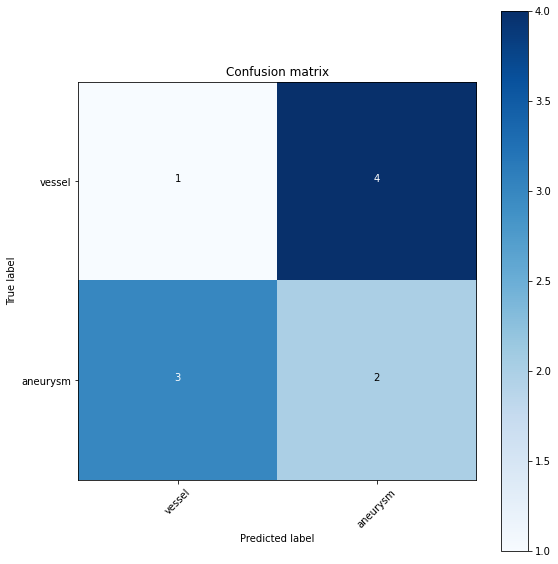

In [80]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, ["vessel", "aneurysm"], normalize=False)